In [1]:
USE_YAM = False
if not USE_YAM:
    DID = ''
else:
    DID = 'y'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import numpy as np

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
import random
random.seed(2021)

In [3]:
if not USE_YAM:
    utr_seq = pd.read_csv('../processed_data/utrs.csv', header = 0)
    utr_seq = utr_seq.loc[:,['Gene Name', 'foreign']]
    utr_seq.rename(columns = {'Gene Name':'gene', 'foreign':'utr_seq'}, inplace = True)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    genes_fi = pd.read_csv('../processed_data/fluorescence_dataset.csv')
    genes_fi.dropna(subset=['intensity'],inplace=True)
    genes_fi = genes_fi.loc[genes_fi.intensity.notna()]
    genes_fi = genes_fi.loc[genes_fi.intensity > 0]
    # genes_fi.intensity, _ = stats.boxcox(genes_fi.intensity)
    fi_trans = [math.log(fi) for fi in genes_fi.intensity]
    genes_fi.intensity = fi_trans
    genes_fi = genes_fi.loc[genes_fi.intensity > -20]
    genes_fi
    df = pd.merge(genes_fi, utr_seq, on = 'gene')
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)
else:
    utr_seq = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    df = utr_seq
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)

In [4]:
df['utr_seq'].apply(lambda x: len(x)).min()

6

<AxesSubplot:>

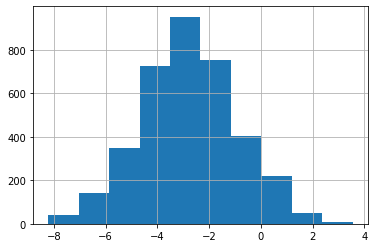

In [5]:
df.intensity.hist()

In [6]:
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

In [7]:
df['int_group'] = np.digitize(df['intensity'].values, df['intensity'].quantile(np.arange(0,1,0.1)).values) - 1
df['int_group'] = df.int_group.astype('category')

In [8]:
df.groupby('int_group').gene.count()

int_group
0    364
1    364
2    364
3    364
4    364
5    364
6    364
7    364
8    364
9    364
Name: gene, dtype: int64

### Sequence features extraction

In [9]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log2(len(i)) for i in df.loc[:,'utr_seq']]

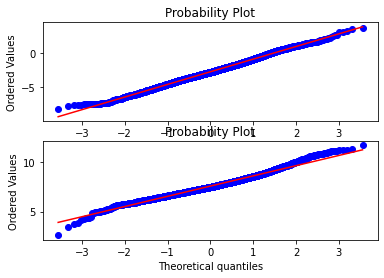

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [11]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [12]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [13]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

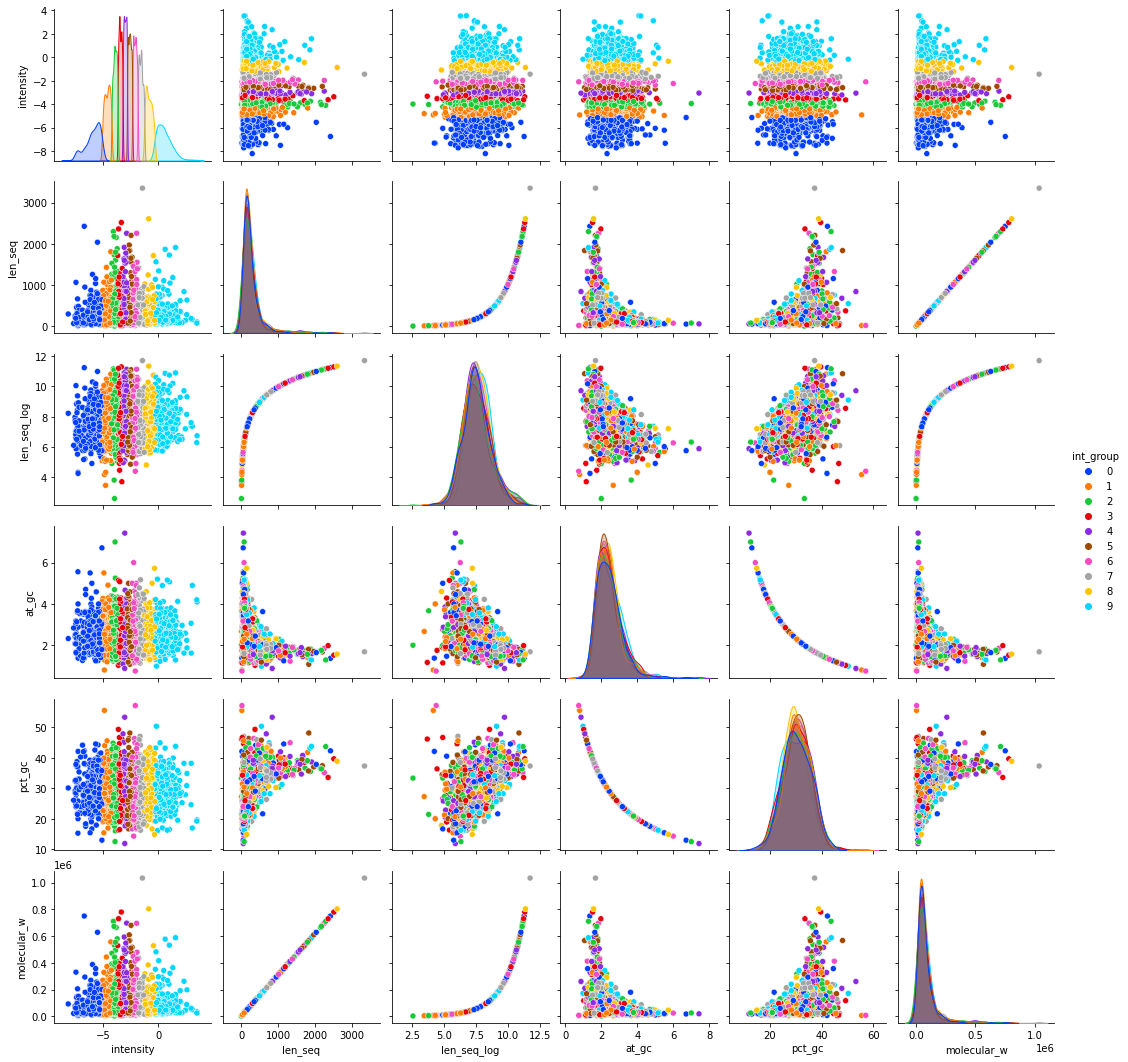

In [14]:
sns.pairplot(df, hue = 'int_group', palette = sns.color_palette('bright', 10))

In [15]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,intensity,len_seq,len_seq_log,at_gc,pct_gc,molecular_w
intensity,1.000000,0.031378,0.085637,0.048036,-0.058530,0.031166
len_seq,0.031378,1.000000,0.843832,-0.383525,0.429759,0.999992
len_seq_log,0.085637,0.843832,1.000000,-0.464112,0.474479,0.843578
at_gc,0.048036,-0.383525,-0.464112,1.000000,-0.960570,-0.383378
pct_gc,-0.058530,0.429759,0.474479,-0.960570,1.000000,0.429639
molecular_w,0.031166,0.999992,0.843578,-0.383378,0.429639,1.000000


### Per group motif discovery (TBC)

[Gibbs Sampling](https://open.oregonstate.education/appliedbioinformatics/chapter/chapter-2-sequence-motifs/).

In [16]:
df.head()

,gene,systematicName,intensity,utr_seq,int_group,len_seq,len_seq_log,at_gc,pct_gc,molecular_w
0,SSA1,YAL005C,2.477076,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...,9,147,7.199672,2.585366,27.891156,45548.2183
1,ERP2,YAL007C,-1.204719,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...,8,286,8.159871,2.445783,29.020979,88087.5535
2,FUN14,YAL008W,-0.785451,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...,8,128,7.000000,2.459459,28.906250,39623.4302
3,SPO7,YAL009W,-3.608608,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...,3,134,7.066089,2.268293,30.597015,41481.5762
4,SWC3,YAL011W,-3.443864,AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...,3,135,7.076816,2.375000,29.629630,41519.5406


In [17]:
import os
import csv
os.makedirs('meme_input', exist_ok=True)
def write_file(x):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{x['int_group'].unique()[0]}.fasta", 'w') as out:
        out.write('\n'.join(p.values))
df.groupby('int_group').apply(write_file)

""


In [18]:
def write_inv_file(x, i):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{i}inv.fasta", 'w') as out:
        out.write('\n'.join(p.values))
for cnt in range(10):
    write_inv_file(df[df['int_group'] != cnt], cnt)

In [19]:
from Bio.motifs import parse

In [20]:
os.environ['PATH'] += os.pathsep + '/home/vaslem/meme/bin:/home/vaslem/meme/libexec/meme-5.4.1'

In [21]:
import pickle
from tqdm.notebook import tqdm

### Trying to find motifs using MEME
- in FI decile group i using background sequences not belonging in i
- in 10th FI decile group using background sequences those in 1st

In [22]:
MINW = 5
MAXW = 10
NMOTIFS = 20
motifs = []
motifs_s = {}
try:
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'rb') as inp:
        motifs_s, motifs = pickle.load(inp)
except IOError:
    for cnt in tqdm(range(10)):
        os.system(
            f'meme meme_input/{cnt}{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/{cnt}{DID}  -dna -neg meme_input/{cnt}{DID}inv.fasta')
        with open(f"meme_output/{cnt}{DID}/meme.txt") as f:
            i_motifs = parse(f, 'MINIMAL')
            motifs_s[cnt] = [str(m.degenerate_consensus) for m in i_motifs]
            motifs.extend(i_motifs)
    os.system(
            f'meme meme_input/9{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/ex{DID} -dna -neg meme_input/0{DID}.fasta')
    with open(f"meme_output/ex{DID}/meme.txt") as f:
        i_motifs = parse(f, 'MINIMAL')
        motifs_s[10] = [str(m.degenerate_consensus) for m in i_motifs]
        motifs.extend(i_motifs)
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'wb') as out:
        pickle.dump((motifs_s, motifs), out)

In [23]:
motifs_s

{0: [],
 1: ['TATATA'],
 2: ['ATATA', 'AAAAA', 'ACATA', 'TTTTTTCT', 'GAAAG'],
 3: ['TATACA', 'TATAT', 'TTTTTTT'],
 4: ['TCTTT', 'TATAT', 'TTTTT', 'AAAAAA', 'ATACA', 'AAAAAG'],
 5: ['ATATA', 'TTTGT', 'TTTTT', 'TGYATR', 'CTTTC', 'AAAAA'],
 6: [],
 7: [],
 8: ['AAAAA'],
 9: ['AAAAAAA',
  'GAAAAG',
  'TTTTYTTTT',
  'AARAAA',
  'TATATAY',
  'GCGCGS',
  'GMGGC',
  'GAGRAG',
  'SCSKGSKGK',
  'ATAAA',
  'CGCCCT'],
 10: ['TTTTYTTTT', 'AAAAA', 'AAAAG', 'GAAGNG']}

In [24]:
seqs = [Seq(x) for x in df['utr_seq']]

In [25]:
from tqdm.notebook import tqdm

In [26]:
def create_features(seqs, motifs):
    scores = np.zeros([len(seqs), len(motifs)])
    counts = np.zeros([len(seqs), len(motifs)])
    for s_c, seq in tqdm(enumerate(seqs)):
        for m_c, motif in enumerate(motifs):
            counts[s_c, m_c] = 0
            if len(seq) < len(motif):
                continue
            weights = motif.pssm
            sc = weights.calculate(seq)
            
            counts[s_c, m_c] = np.sum(sc > 0)
            if not counts[s_c, m_c]:
                continue
            scores[s_c, m_c] = np.median(sc[sc>0])
                
    return counts, scores
    
            
counts, scores = create_features(seqs, motifs)

In [27]:
columns = [str(m.degenerate_consensus) for m in motifs]
columns_scores = [c + '_' + '_score' for c in columns]
columns_tfidf = [c + '_tfidf' for c in columns]
raw_columns_scores = columns_scores
columns_scores = list(set(columns_scores))
raw_columns_tfidf = columns_tfidf
columns_tfidf = list(set(columns_tfidf))
raw_columns = raw_columns_scores + raw_columns_tfidf
columns = list(set(raw_columns))

In [28]:
counts

array([[5., 6., 0., ..., 0., 0., 1.],
       [0., 3., 4., ..., 4., 1., 0.],
       [0., 2., 5., ..., 5., 0., 0.],
       ...,
       [1., 5., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 7., ..., 7., 0., 1.]])

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer().fit_transform(counts)
tfidf = tfidf.todense()

In [30]:
featDf = pd.DataFrame(np.hstack([scores, tfidf]), columns=raw_columns)
featDf = featDf.loc[:,~featDf.columns.duplicated()]

In [31]:
featDf.fillna(0, inplace=True)

In [32]:
featDf['intensity'] = df['intensity']
featDf['int_group'] = df['int_group']

Checking for significant difference in FI between genes with and without efficiency element.

In [33]:
p_vals = []
for e in columns:
    grp0 = featDf.loc[featDf[e] == 0].intensity
    grp1 = featDf.loc[featDf[e] != 0].intensity
    f_val, p_val = stats.ttest_ind(grp0, grp1)            
    print(f"({e} size0 = {len(grp0)}, size1 = {len(grp1)}) One-way ANOVA P ={p_val}")
    p_vals.append(p_val)

(GCGCGS__score size0 = 3560, size1 = 80) One-way ANOVA P =0.12582108895174154
(TATATA__score size0 = 1531, size1 = 2109) One-way ANOVA P =2.802881970036265e-07
(TTTTTTT__score size0 = 2591, size1 = 1049) One-way ANOVA P =0.00302757486073876
(AAAAAAA__score size0 = 2757, size1 = 883) One-way ANOVA P =0.0001222114489403133
(ATATA_tfidf size0 = 768, size1 = 2872) One-way ANOVA P =1.4112059052264719e-05
(GAAAAG__score size0 = 2971, size1 = 669) One-way ANOVA P =0.27183355289095373
(AAAAAA__score size0 = 2275, size1 = 1365) One-way ANOVA P =1.8505466787923124e-05
(TATAT__score size0 = 795, size1 = 2845) One-way ANOVA P =1.9402731954407346e-08
(ATACA__score size0 = 1318, size1 = 2322) One-way ANOVA P =0.13360267040313026
(AAAAG__score size0 = 1914, size1 = 1726) One-way ANOVA P =0.5161745177723926
(ACATA_tfidf size0 = 1870, size1 = 1770) One-way ANOVA P =0.9141164542402505
(TGYATR_tfidf size0 = 1594, size1 = 2046) One-way ANOVA P =2.343024885718502e-05
(GAAAAG_tfidf size0 = 2971, size1 = 669

In [34]:
from statsmodels.stats.multitest import fdrcorrection
q_vals = fdrcorrection(p_vals)[1]

In [35]:
ordering = np.argsort(q_vals)
np.array(columns)[ordering]

array(['TATATAY_tfidf', 'TATATAY__score', 'TTTTT__score', 'TTTTT_tfidf',
       'TATAT_tfidf', 'TATAT__score', 'AARAAA__score', 'AARAAA_tfidf',
       'TTTGT_tfidf', 'TTTGT__score', 'TATATA_tfidf', 'TATATA__score',
       'TTTTYTTTT_tfidf', 'TTTTYTTTT__score', 'TCTTT__score',
       'TCTTT_tfidf', 'ATATA_tfidf', 'ATATA__score', 'AAAAAA_tfidf',
       'AAAAAA__score', 'TGYATR__score', 'TGYATR_tfidf', 'ATAAA_tfidf',
       'ATAAA__score', 'GAAGNG__score', 'GAAGNG_tfidf', 'AAAAAAA__score',
       'AAAAAAA_tfidf', 'AAAAA_tfidf', 'AAAAA__score', 'CTTTC__score',
       'CTTTC_tfidf', 'TTTTTTT__score', 'TTTTTTT_tfidf',
       'SCSKGSKGK_tfidf', 'SCSKGSKGK__score', 'GCGCGS_tfidf',
       'GCGCGS__score', 'ATACA__score', 'ATACA_tfidf', 'GAAAG_tfidf',
       'GAAAG__score', 'GAGRAG_tfidf', 'GAGRAG__score', 'GAAAAG_tfidf',
       'GAAAAG__score', 'TTTTTTCT__score', 'TTTTTTCT_tfidf',
       'TATACA__score', 'TATACA_tfidf', 'AAAAG__score', 'AAAAG_tfidf',
       'CGCCCT_tfidf', 'CGCCCT__score', 'AAA

In [36]:
sig_mots = np.array(columns)[q_vals < 0.05]

In [37]:
len(sig_mots)

34

In [38]:
sig_mots

array(['TATATA__score', 'TTTTTTT__score', 'AAAAAAA__score', 'ATATA_tfidf',
       'AAAAAA__score', 'TATAT__score', 'TGYATR_tfidf',
       'TTTTYTTTT__score', 'TCTTT_tfidf', 'AARAAA__score', 'TTTTT__score',
       'CTTTC_tfidf', 'CTTTC__score', 'AAAAA__score', 'AAAAA_tfidf',
       'TTTGT_tfidf', 'AAAAAAA_tfidf', 'TATATAY_tfidf', 'TCTTT__score',
       'TGYATR__score', 'GAAGNG_tfidf', 'TTTTTTT_tfidf', 'ATAAA_tfidf',
       'TTTTT_tfidf', 'GAAGNG__score', 'TATATAY__score',
       'TTTTYTTTT_tfidf', 'TATATA_tfidf', 'AAAAAA_tfidf', 'AARAAA_tfidf',
       'TATAT_tfidf', 'ATATA__score', 'TTTGT__score', 'ATAAA__score'],
      dtype='<U16')

In [39]:
featDf['int_group'] = featDf['int_group'].astype(float)

In [40]:
# sns.pairplot(df[sig_mots.tolist() + ['int_group']], hue = 'int_group', palette = sns.color_palette('bright', 10))

### PCA

In [41]:
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/plotly/version.py'>


In [42]:
from sklearn.decomposition import PCA
import plotly.express as px

In [43]:
features = columns_tfidf + columns_scores

In [44]:
df_temp = featDf[features]
# df_temp = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
df_temp = (df_temp-df_temp.mean())/df_temp.std()
# df_temp = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
df_temp

,ATATA_tfidf,ACATA_tfidf,GAAAAG_tfidf,TGYATR_tfidf,GAGRAG_tfidf,TCTTT_tfidf,CTTTC_tfidf,TATACA_tfidf,AAAAA_tfidf,AAAAAAA_tfidf,...,TATACA__score,TCTTT__score,TGYATR__score,GAAGNG__score,TATATAY__score,GMGGC__score,ATATA__score,TTTGT__score,GAGRAG__score,ATAAA__score
0,1.768341,0.115778,-0.384464,-0.720415,-0.426879,0.228452,-0.588468,0.918840,-0.940532,-0.478160,...,1.720469,0.982975,-1.111822,1.057212,0.918941,2.901036,0.517045,-0.882534,-0.536474,-1.879200
1,-0.073487,-0.619061,-0.384464,0.296593,-0.426879,-0.763111,-0.588468,-0.445206,0.593987,-0.478160,...,-0.581077,-1.017041,0.944799,-0.804893,0.503009,-0.355635,0.517045,1.132789,-0.536474,0.153689
2,-0.312120,-0.046560,-0.384464,-0.720415,-0.426879,0.009399,0.270295,1.680206,1.227720,2.182272,...,1.720469,0.982975,-1.111822,-0.804893,-1.270536,-0.355635,0.517045,-0.882534,-0.536474,0.153689
3,-1.041933,0.909931,-0.384464,-0.720415,-0.426879,-0.763111,-0.588468,2.392986,-0.940532,-0.478160,...,1.720469,-1.017041,-1.111822,1.663471,-1.270536,-0.355635,-1.933535,-0.882534,-0.536474,0.932786
4,-1.041933,-0.619061,-0.384464,2.029689,-0.426879,-0.763111,-0.588468,2.096999,-0.940532,-0.478160,...,1.720469,-1.017041,1.052856,-0.804893,0.503009,-0.355635,-1.933535,-0.882534,-0.536474,-1.879200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,-1.041933,-0.619061,-0.384464,6.804389,-0.426879,-0.763111,-0.588468,-0.445206,-0.940532,-0.478160,...,-0.581077,-1.017041,0.944799,-0.804893,-1.270536,-0.355635,-1.933535,-0.882534,-0.536474,-1.879200
3636,-1.041933,-0.619061,-0.384464,-0.334075,-0.426879,0.275332,-0.588468,-0.445206,-0.649066,-0.478160,...,-0.581077,0.982975,1.247571,-0.804893,-1.270536,-0.355635,-1.933535,1.132789,-0.536474,0.153689
3637,1.756112,1.136879,-0.384464,0.161090,-0.426879,0.421587,2.045475,1.184526,-0.275500,-0.478160,...,1.720469,0.982975,0.944799,-0.804893,0.577054,-0.355635,0.517045,1.132789,-0.536474,0.932786
3638,-1.041933,-0.619061,-0.384464,3.040641,-0.426879,4.291554,-0.588468,-0.445206,-0.940532,-0.478160,...,-0.581077,0.982975,0.555190,-0.804893,-1.270536,-0.355635,-1.933535,-0.882534,-0.536474,-1.879200


In [45]:
%matplotlib inline

In [46]:
pca = PCA(n_components = 7)
components = pca.fit_transform(df_temp)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [47]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=df.int_group)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [48]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Classification (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [49]:

# df_temp = pd.DataFrame(components)
df_temp = featDf.loc[:, features]

# df_temp = (df_temp-df_temp.mean())/df_temp.std()
df_temp

,ATATA_tfidf,ACATA_tfidf,GAAAAG_tfidf,TGYATR_tfidf,GAGRAG_tfidf,TCTTT_tfidf,CTTTC_tfidf,TATACA_tfidf,AAAAA_tfidf,AAAAAAA_tfidf,...,TATACA__score,TCTTT__score,TGYATR__score,GAAGNG__score,TATATAY__score,GMGGC__score,ATATA__score,TTTGT__score,GAGRAG__score,ATAAA__score
0,0.339859,0.078799,0.0,0.000000,0.0,0.076751,0.000000,0.108791,0.000000,0.000000,...,10.454471,8.714568,0.000000,7.595661,9.461782,12.231519,8.000465,0.00000,0.0,0.000000
1,0.117118,0.000000,0.0,0.099477,0.0,0.000000,0.000000,0.000000,0.192639,0.000000,...,0.000000,0.000000,8.733729,0.000000,7.664340,0.000000,8.000465,8.82778,0.0,5.582114
2,0.088260,0.061391,0.0,0.000000,0.0,0.059795,0.069651,0.169515,0.272196,0.258544,...,10.454471,8.714568,0.000000,0.000000,0.000000,0.000000,8.000465,0.00000,0.0,5.582114
3,0.000000,0.163958,0.0,0.000000,0.0,0.000000,0.000000,0.226363,0.000000,0.000000,...,10.454471,0.000000,0.000000,10.068635,0.000000,0.000000,0.000000,0.00000,0.0,7.721439
4,0.000000,0.000000,0.0,0.268997,0.0,0.000000,0.000000,0.202756,0.000000,0.000000,...,10.454471,0.000000,9.192608,0.000000,7.664340,0.000000,0.000000,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,0.000000,0.000000,0.0,0.736027,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.733729,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
3636,0.000000,0.000000,0.0,0.037789,0.0,0.080380,0.000000,0.000000,0.036590,0.000000,...,0.000000,8.714568,10.019491,0.000000,0.000000,0.000000,0.000000,8.82778,0.0,5.582114
3637,0.338380,0.188295,0.0,0.086223,0.0,0.091700,0.213628,0.129981,0.083486,0.000000,...,10.454471,8.714568,8.733729,0.000000,7.984324,0.000000,8.000465,8.82778,0.0,7.721439
3638,0.000000,0.000000,0.0,0.367882,0.0,0.391252,0.000000,0.000000,0.000000,0.000000,...,0.000000,8.714568,7.079198,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000


In [50]:
from sklearn.model_selection import train_test_split
df_subset = featDf[featDf['int_group'].isin([0,9])].copy()
df_subset = featDf.copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_bool, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

Mean accuracy score: 0.627


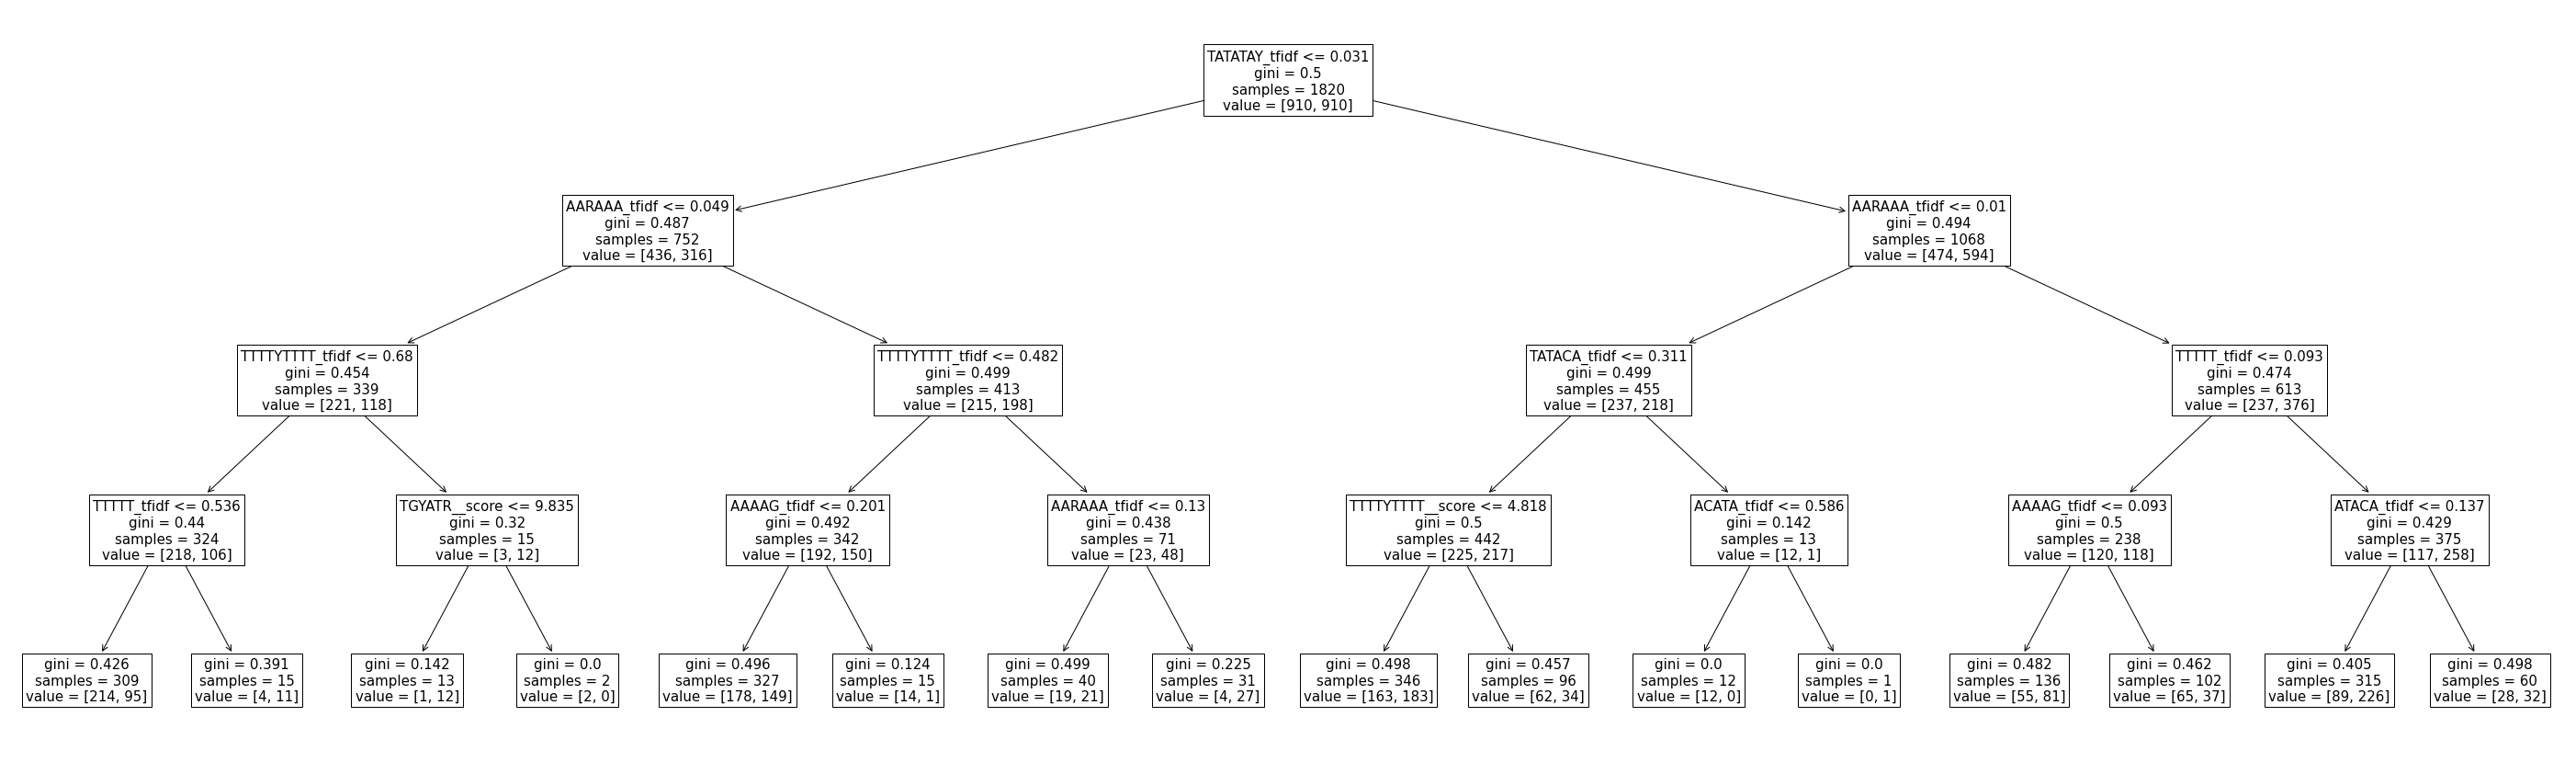

In [51]:

from sklearn.tree import DecisionTreeClassifier
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
predicted = t.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
from sklearn.tree import plot_tree
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)

In [53]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.57
Mean accuracy score: 0.999


In [54]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.57
Mean accuracy score: 0.559


<AxesSubplot:>

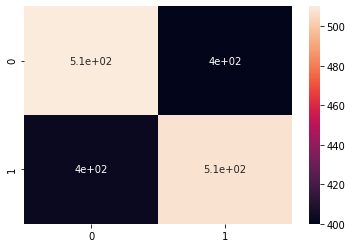

In [55]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

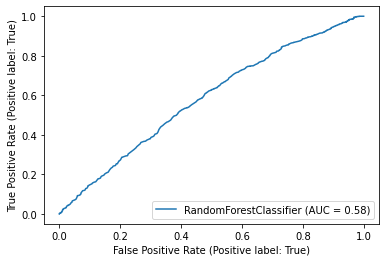

In [56]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [57]:
df_subset.shape

(3640, 63)

In [58]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_group, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [59]:
from sklearn.metrics import mean_squared_error as mse

In [60]:
np.sqrt(np.sum((y_train - np.mean(y_train))**2)/len(y_train))

2.8717632977795393

Mean squared score: 7.42


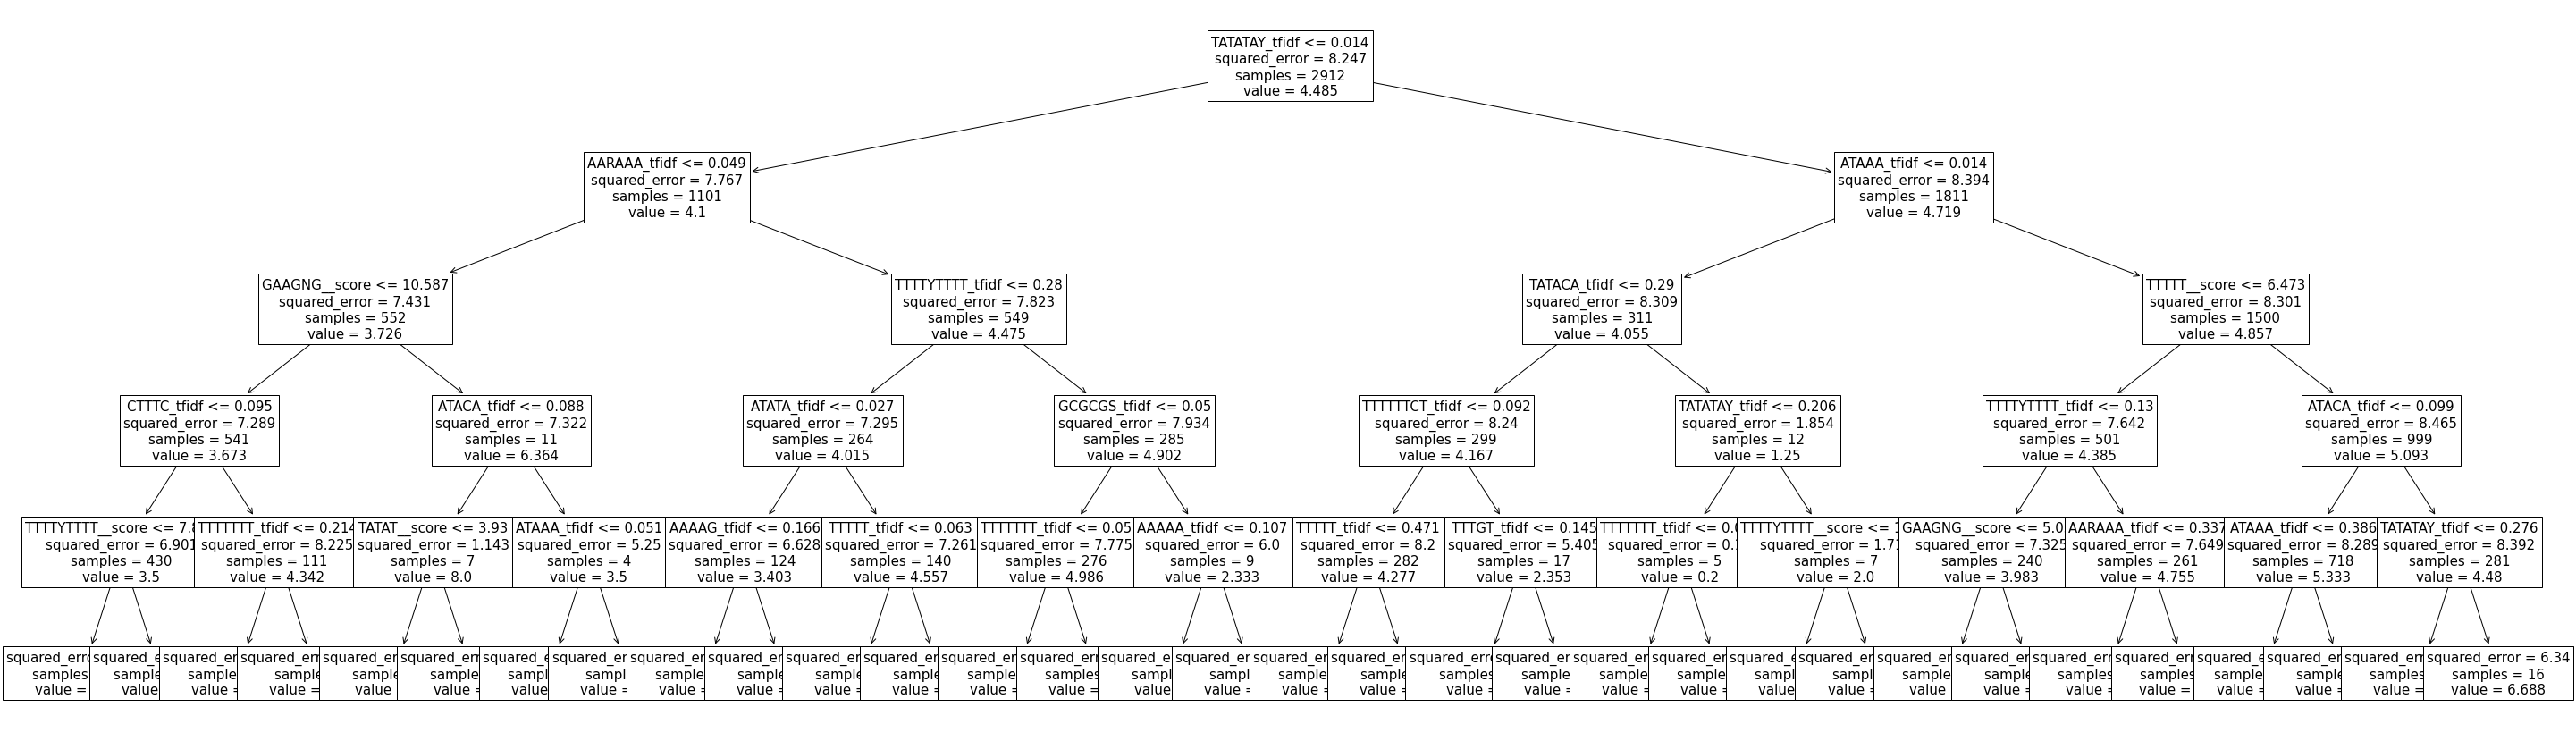

In [61]:
from sklearn.tree import DecisionTreeRegressor
t = DecisionTreeRegressor(random_state=123456, max_depth=5)
t.fit(X_train, y_train)
predicted = t.predict(X_train)
m = mse(y_train, predicted)
print(f'Mean squared score: {m:.3}')
from sklearn.tree import plot_tree
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [63]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.0124
Test data R-2 score: 0.0179
Test data Spearman correlation: 0.158
Test data Pearson correlation: 0.161


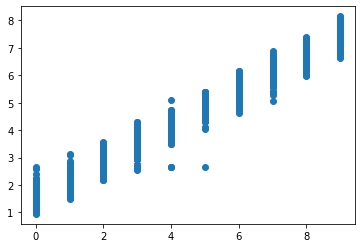

In [64]:
plt.scatter(y_train, predicted_train)

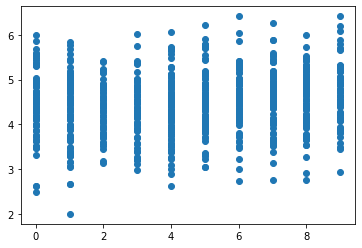

In [65]:
plt.scatter(y_test, predicted_test)

In [66]:
from umap.umap_ import UMAP

In [67]:
mapper = UMAP().fit(df_temp[features])

<AxesSubplot:>

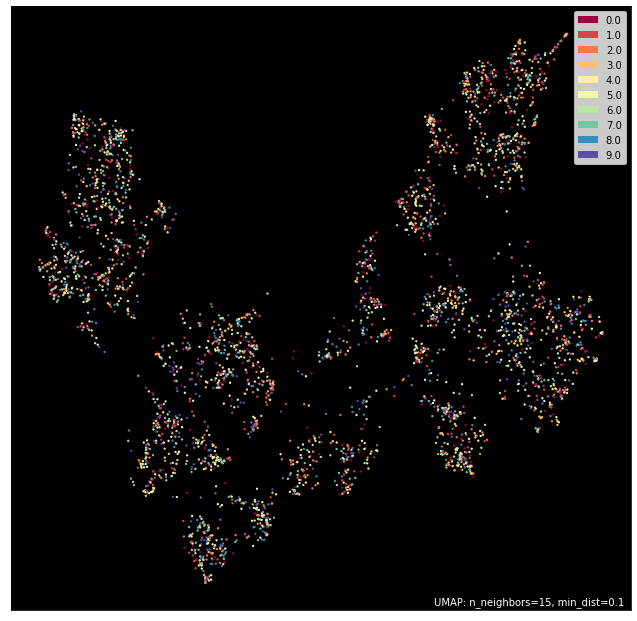

In [68]:
import umap.plot  # pip install umap-learn[plot]

umap.plot.points(mapper, labels=featDf['int_group'], theme="viridis")

In [69]:
counts.shape

(3640, 37)

In [70]:
len(raw_columns)

74

In [71]:
a = [str(m.degenerate_consensus) for m in motifs]
_, p = np.unique(a, return_index=True)
uni_cols = np.array([str(m.degenerate_consensus) for m in motifs])[p].tolist()

In [72]:
countsDf = pd.DataFrame(counts[:, p], columns= uni_cols)
countsDf['intensity'] = df['intensity']

In [73]:
tfidfDf = countsDf.copy()
tfidfDf[:] = TfidfTransformer().fit_transform(countsDf).todense()
tfidfDf['intensity'] = df['intensity']

<AxesSubplot:>

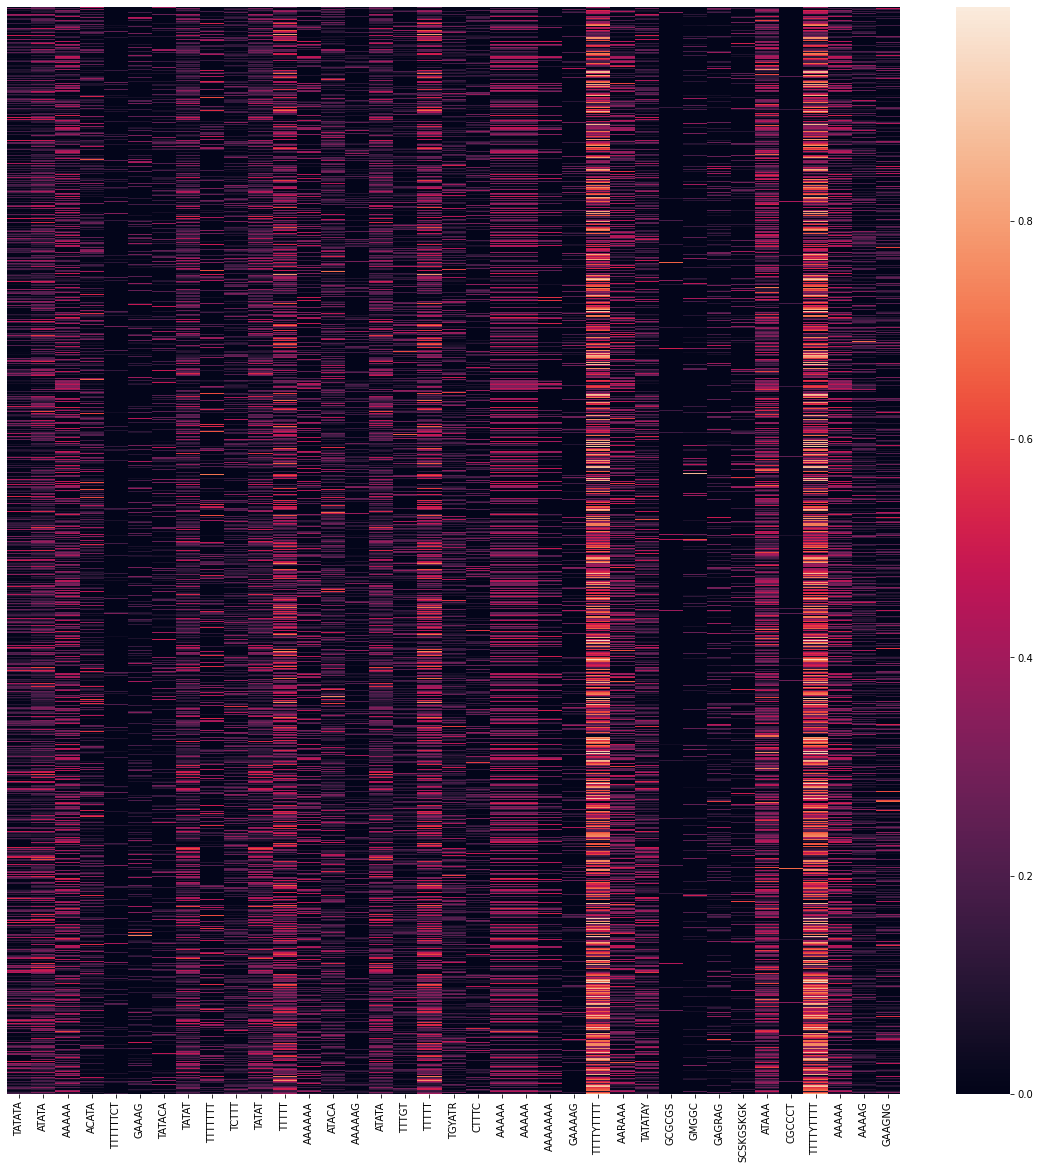

In [74]:
plt.figure(figsize=(20,20))
sns.heatmap(tfidfDf.sort_values('intensity')[a],yticklabels=False)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



<Figure size 1440x1440 with 0 Axes>

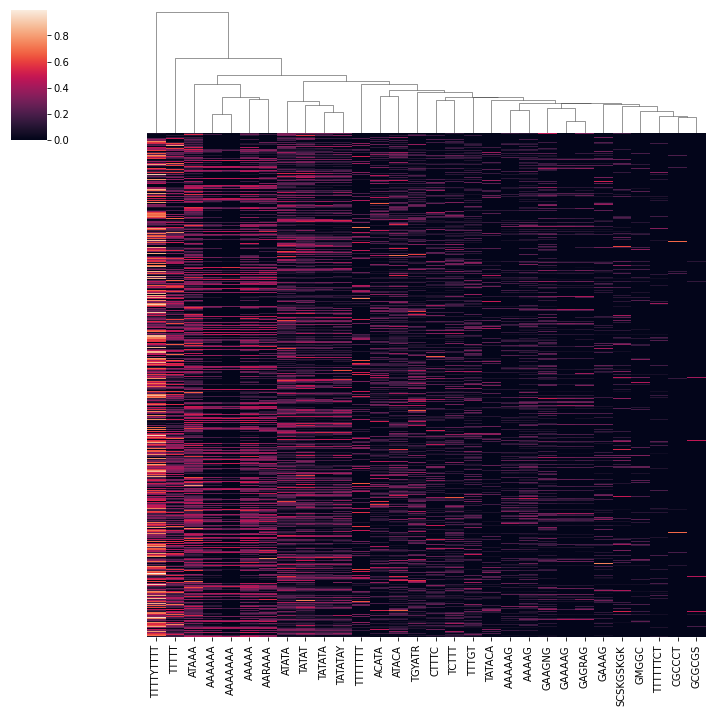

In [75]:
plt.figure(figsize=(20,20))
sns.clustermap(tfidfDf.sort_values('intensity')[uni_cols],yticklabels=False,row_cluster=False)

In [76]:
motifs_s

{0: [],
 1: ['TATATA'],
 2: ['ATATA', 'AAAAA', 'ACATA', 'TTTTTTCT', 'GAAAG'],
 3: ['TATACA', 'TATAT', 'TTTTTTT'],
 4: ['TCTTT', 'TATAT', 'TTTTT', 'AAAAAA', 'ATACA', 'AAAAAG'],
 5: ['ATATA', 'TTTGT', 'TTTTT', 'TGYATR', 'CTTTC', 'AAAAA'],
 6: [],
 7: [],
 8: ['AAAAA'],
 9: ['AAAAAAA',
  'GAAAAG',
  'TTTTYTTTT',
  'AARAAA',
  'TATATAY',
  'GCGCGS',
  'GMGGC',
  'GAGRAG',
  'SCSKGSKGK',
  'ATAAA',
  'CGCCCT'],
 10: ['TTTTYTTTT', 'AAAAA', 'AAAAG', 'GAAGNG']}

### Try only with last motifs group and using groups 0 and 9

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
subset_feats = ([x + '__score' for x in motifs_s[10]] +
                       [x + '_tfidf' for x in motifs_s[10]])

df_subset = featDf.loc[featDf['int_group'].isin([0,9]), subset_feats + ['int_group']
                       ].copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,subset_feats], df_subset.int_bool, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy train score: {accuracy:.3}')
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy test score: {accuracy:.3}')

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Out-of-bag score estimate: 0.5
Mean accuracy train score: 0.997
Mean accuracy test score: 0.591
